<a href="https://colab.research.google.com/github/Juliarty/kdd-project/blob/main/Kdd_eyes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Подготовка данных и модели.

В качестве данных взят датасет https://www.kaggle.com/pavelbiz/eyes-rtte, который представляет собой набор изображений мужских и женских глаз. Также в данном ноутбуке используется модель, обученная с использованием кода из https://www.kaggle.com/davidbroberts/male-or-female-eyes-simple-cnn.

In [ ]:
!gdown --id 1A8ACXIBt9vYncvjOkeHz3bYraZsDXMXF 

Downloading...
From: https://drive.google.com/uc?id=1A8ACXIBt9vYncvjOkeHz3bYraZsDXMXF
To: /content/eyes-rtte-train-test-split.zip
100% 43.1M/43.1M [00:00<00:00, 131MB/s] 


In [ ]:
!unzip -q -n eyes-rtte-train-test-split.zip

In [ ]:
# Do imports
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt



In [ ]:
# Setup some config variables
batch_size = 50
image_size = (256,256)
base_path = './data'
test_path = base_path + '/test'
train_path = base_path + '/train'

seed = 42

In [ ]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_path,
    image_size = image_size,
    batch_size = batch_size,
)

Found 1154 files belonging to 2 classes.


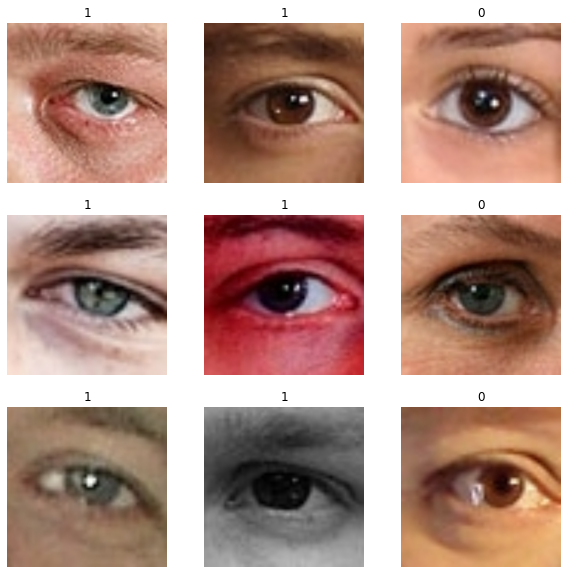

In [ ]:
# Display a few images, label 0 is female, label 1 is male
plt.figure(figsize=(10, 10))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [ ]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = inputs
    #x = data_augmentation(inputs)

    # Entry block
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU(max_value=1.0)(x)
    
    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        #x = layers.Activation("relu")(x)
        x = layers.ReLU(max_value=1.0)(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)
        x = layers.ReLU(max_value=1.0)(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(previous_block_activation)
        
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU(max_value=1.0)(x)
    
    x = layers.GlobalAveragePooling2D()(x)
    activation = "softmax"
    units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)

model = make_model(input_shape=image_size + (3,), num_classes=2)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 256, 256, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 32  896         ['rescaling[0][0]']              
                                )                                                                 
                                                                                              

In [ ]:
# download the trained model
!mkdir model
!cd model
!gdown --id 1iwcQx4WLNJY3PCGEI-YYd3pfWsq9xPjP -O model/model_parameters.h5

mkdir: cannot create directory ‘model’: File exists
Downloading...
From: https://drive.google.com/uc?id=1iwcQx4WLNJY3PCGEI-YYd3pfWsq9xPjP
To: /content/model/model_parameters.h5
100% 33.6M/33.6M [00:00<00:00, 127MB/s] 


In [ ]:
model.compile(optimizer=keras.optimizers.Adam(1e-3), loss="sparse_categorical_crossentropy", metrics=["sparse_categorical_accuracy"])
model.load_weights('./model/model_parameters.h5')

In [ ]:
#loss, acc = model.evaluate(test_ds, verbose=2)
#print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

#1. Поиск примеров.

In [ ]:
# Returns the probability vector
def predict_image(image_path):
    img = keras.preprocessing.image.load_img(image_path, target_size=image_size)
    img_array = keras.preprocessing.image.img_to_array(img)
    # Image needs to be in the form of a batch
    img_array = tf.expand_dims(img_array, 0)

    return model.predict(img_array)[0]

In [ ]:
from glob import glob
female_img_to_prediction = {file_path: predict_image(file_path) for file_path in glob('data/test/femaleeyes/*')}

In [ ]:
male_img_to_prediction = {file_path: predict_image(file_path) for file_path in glob('data/test/maleeyes/*')}

In [ ]:
# 2 примера правильно классифицированных с высокой вероятностью принадлежности к классу

def show_image(image_path):
    img = keras.preprocessing.image.load_img(image_path, target_size=image_size)
    img_array = keras.preprocessing.image.img_to_array(img)

    # Image needs to be in the form of a batch
    img_array = tf.expand_dims(img_array, 0)

    # Predict & score
    predictions = model.predict(img_array)
    score = predictions[0]
    print("This image is %.2f percent female and %.2f percent male." % (100 * score[0], 100 * score[1]))
    plt.imshow(img);

In [ ]:
# 2 примера правильно классифицированных с высокой вероятностью принадлежности к классу

import numpy as np
def get_example(img_to_prediction, closest_to, greater_than=0, less_than=1):
  for item in img_to_prediction.items():
    img = item[0]
    male_prob = item[1][1]
    dist = np.abs(closest_to - male_prob)

    if male_prob <= less_than and greater_than <= male_prob:
      break

  for item in img_to_prediction.items():
    male_prob = item[1][1]
    if np.abs(closest_to - male_prob) < dist \
    and male_prob >= greater_than and male_prob <= less_than:
        img = item[0]
        dist = np.abs(closest_to - male_prob)

  return img


This image is 1.01 percent female and 98.99 percent male.


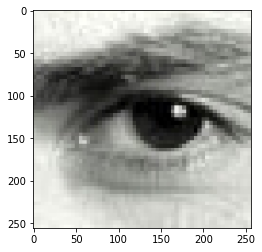

In [ ]:
# правильно классифицированный мужчина с высокой вероятностью принадлежности к классу
true_high_male_img_path = get_example(male_img_to_prediction, 1, 0.5, 0.99)
show_image(true_high_male_img_path)

This image is 98.94 percent female and 1.06 percent male.


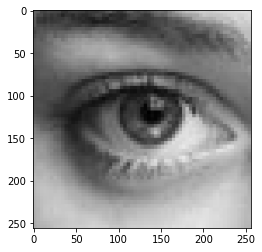

In [ ]:
# правильно классифицированная женщина с высокой вероятностью принадлежности к классу
true_high_female_img_path = get_example(female_img_to_prediction, 0, 0.01, 0.5)
show_image(true_high_female_img_path)

This image is 40.06 percent female and 59.94 percent male.


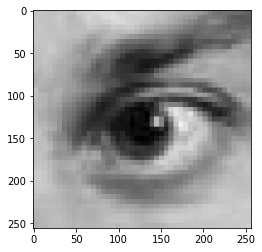

In [ ]:
# правильно классифицированный мужчина с низкой вероятностью принадлежности к классу
true_low_male_img_path = get_example(male_img_to_prediction, 1, 0.5, 0.6)
show_image(true_low_male_img_path)


This image is 59.74 percent female and 40.26 percent male.


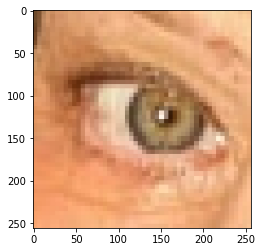

In [ ]:
# правильно классифицированная женщина с низкой вероятностью принадлежности к классу
true_low_female_img_path = get_example(female_img_to_prediction, 0, 0.4, 0.5)
show_image(true_low_female_img_path)


This image is 99.60 percent female and 0.40 percent male.


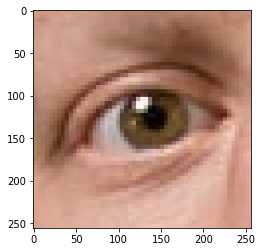

In [ ]:
# неправильно классифицированный мужчина с высокой вероятностью принадлежности к классу
false_lowest_male_img_path = get_example(male_img_to_prediction, 0, 0, 0.5)
show_image(false_lowest_male_img_path)

This image is 0.91 percent female and 99.09 percent male.


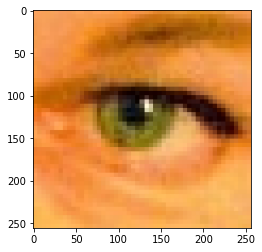

In [ ]:
# неправильно классифицированная женщина с высокой вероятностью принадлежности к классу
false_lowest_female_img_path = get_example(female_img_to_prediction, 1, 0.5, 1)
show_image(false_lowest_female_img_path)

This image is 59.82 percent female and 40.18 percent male.


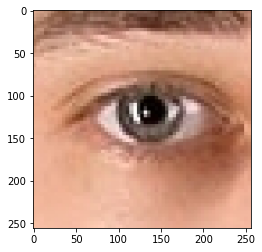

In [ ]:
# неправильно классифицированный мужчина с низкой вероятностью принадлежности к классу
false_low_male_img_path = get_example(male_img_to_prediction, 0, 0.4, 0.5)
show_image(false_low_male_img_path)

This image is 40.48 percent female and 59.52 percent male.


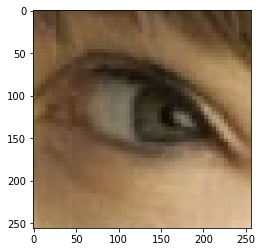

In [ ]:
# неправильно классифицированная женщина с низкой вероятностью принадлежности к классу
false_low_female_img_path = get_example(female_img_to_prediction, 1, 0.5, 0.6)
show_image(false_low_female_img_path)

# 2. LIME and SHAP.

In [ ]:
%%capture
!pip install lime
!pip install shap

In [ ]:
from lime import lime_image
import shap
from skimage.segmentation import mark_boundaries

In [ ]:
image_shape = (256, 256, 3)
class_names = ['female', 'male']

In [ ]:
def image_array(image_path):
    img = keras.preprocessing.image.load_img(image_path, target_size=image_size)
    img_array = keras.preprocessing.image.img_to_array(img).astype('double')
    return img_array

In [ ]:
def predict_fn(img_array):
    return model.predict(img_array)

In [ ]:
lime_explainer = lime_image.LimeImageExplainer(random_state=0)

In [ ]:
shap_masker = shap.maskers.Image("inpaint_telea", image_shape)
shap_explainer = shap.Explainer(predict_fn, shap_masker, output_names=class_names)

In [ ]:
def lime_plot_class_explanation(explanation, class_idx):
    temp, mask = explanation.get_image_and_mask(
        label=class_idx, 
        positive_only=False, 
        num_features=10, 
        hide_rest=False,
    )
    return temp, mask

In [ ]:
def lime_explanation(image_path):
    image = image_array(image_path)
    explanation = lime_explainer.explain_instance(
        image, 
        predict_fn,
        top_labels=2, 
        hide_color=0, 
        num_samples=1000,
        random_seed=0,
    )
    
    temp_female, mask_female = lime_plot_class_explanation(explanation, 0)
    temp_male, mask_male = lime_plot_class_explanation(explanation, 1)

    fig, (ax1, ax2) = plt.subplots(1, 2)

    ax1.imshow(mark_boundaries(temp_female / 255, mask_female))
    ax1.set_title(class_names[0])

    ax2.imshow(mark_boundaries(temp_male / 255, mask_male))
    ax2.set_title(class_names[1])

    plt.show()

In [ ]:
def shap_explanation(image_path):
    image = image_array(image_path)
    shap_values = shap_explainer(
        [image], 
        max_evals=5000, 
        batch_size=50, 
        outputs=shap.Explanation.argsort.flip[:4]
    )

    shap.image_plot(shap_values[0], pixel_values=shap_values.data[0])

In [ ]:
def explain_lime_and_shap(image_path):
    lime_explanation(image_path)
    shap_explanation(image_path)

  0%|          | 0/1000 [00:00<?, ?it/s]

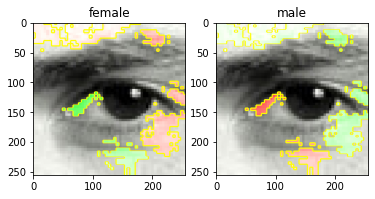

  0%|          | 0/2498 [00:00<?, ?it/s]

Partition explainer: 2it [08:04, 484.94s/it]              


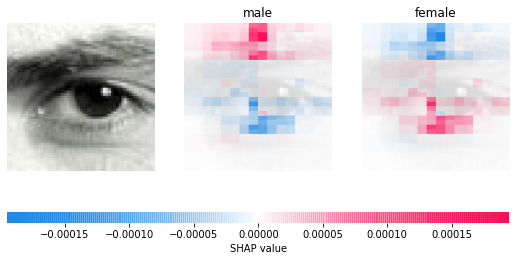

In [ ]:
# правильно классифицированный мужчина с высокой вероятностью принадлежности к классу
explain_lime_and_shap(true_high_male_img_path)

LIME для выделил область над бровью и угол верхнего и нижнего века в качестве объяснения, что на изображении мужчина. SHAP также указал на область над бровью, однако угол века относит к области сигнализирующей об изображении женщины.

  0%|          | 0/1000 [00:00<?, ?it/s]

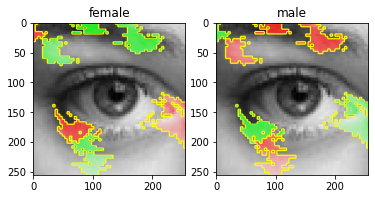

  0%|          | 0/2498 [00:00<?, ?it/s]

Partition explainer: 2it [08:07, 487.25s/it]              


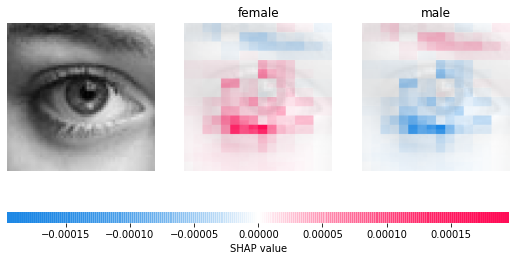

In [ ]:
# правильно классифицированная женщина с высокой вероятностью принадлежности к классу
explain_lime_and_shap(true_high_female_img_path)

На данном изображении LIME выделяет бровь как признак изображения женщины, однако SHAP данную область относит к сигналу о мужчине.

  0%|          | 0/1000 [00:00<?, ?it/s]

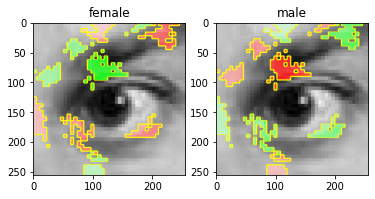

  0%|          | 0/2498 [00:00<?, ?it/s]

Partition explainer: 2it [07:45, 465.54s/it]              


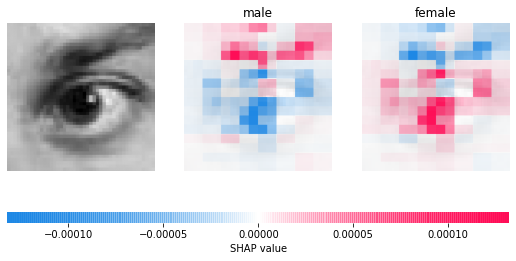

In [ ]:
# правильно классифицированный мужчина с низкой вероятностью принадлежности к классу
explain_lime_and_shap(true_low_male_img_path)

LIME в качестве мужской области выделяет угол глаза у переносицы и часть нижнего века, а также участок брови. Участок брови у переносицы относится к женской области. SHAP также выделяет участок брови мужским, однако участок брови у переносицы неоднозначно относит к признаку женского изображения.

  0%|          | 0/1000 [00:00<?, ?it/s]

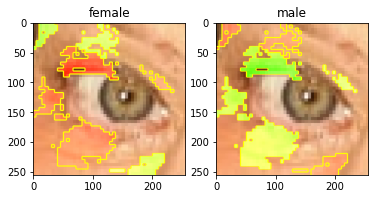

  0%|          | 0/2498 [00:00<?, ?it/s]

Partition explainer: 2it [07:51, 471.10s/it]              


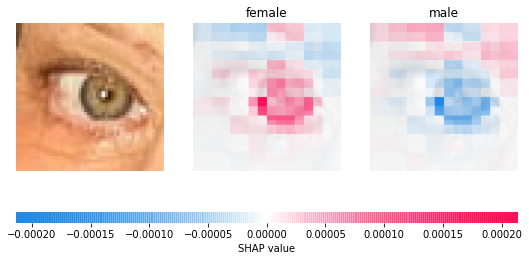

In [ ]:
# правильно классифицированная женщина с низкой вероятностью принадлежности к классу
explain_lime_and_shap(true_low_female_img_path)

На данном изображении LIME практически неинтерпретируемо выделяет женские области. В качестве свидетесть мужского изображения выделяются ресницы на верхнем веке морщины на нижнем. SHAP в качестве мужкой области определяет зону у брови, а в качестве женской - границу радужки.

  0%|          | 0/1000 [00:00<?, ?it/s]

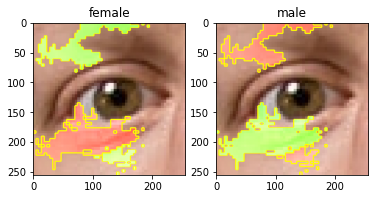

  0%|          | 0/2498 [00:00<?, ?it/s]

Partition explainer: 2it [08:49, 529.26s/it]              


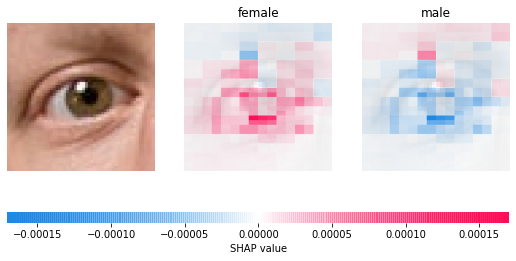

In [ ]:
# неправильно классифицированный мужчина с высокой вероятностью принадлежности к классу
explain_lime_and_shap(false_lowest_male_img_path)

В LIME зона над верхним веком свидетельствует об изображении женщины, а нижнее веко и морщины - мужчины. SHAP наоборот относит нижнее веко к женскому изображению, а небольшой участок над веком к мужскому.

  0%|          | 0/1000 [00:00<?, ?it/s]

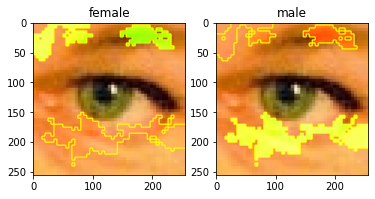

  0%|          | 0/2498 [00:00<?, ?it/s]

Partition explainer: 2it [08:33, 513.97s/it]              


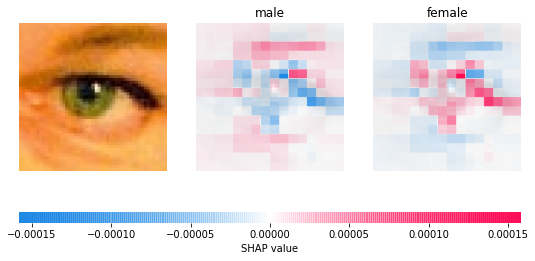

In [ ]:
# неправильно классифицированная женщина с высокой вероятностью принадлежности к классу
explain_lime_and_shap(false_lowest_female_img_path)

На данном изображении в LIME нижнее веко свидетельствует о наличии мужского изображения, а участки брови о женском классе. SHAP также обратил внимание на нижнее веко как свибетельсво о мужчине, однако также отметил участок под бровью. В качестве женской области выделились ресницы.

  0%|          | 0/1000 [00:00<?, ?it/s]

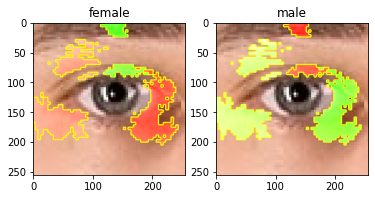

  0%|          | 0/2498 [00:00<?, ?it/s]

Partition explainer: 2it [07:51, 471.84s/it]              


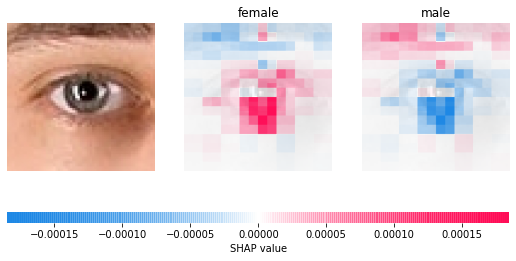

In [ ]:
# неправильно классифицированный мужчина с низкой вероятностью принадлежности к классу
explain_lime_and_shap(false_low_male_img_path)

LIME выделил совсем небольшие женские участки на изображении, это бровь и верхнее веко, более ярко выделены углы глаз как свидетельство о мужском изображении. SHAP выделяет бровь как мужскую область, а ресницы как женскую.

  0%|          | 0/1000 [00:00<?, ?it/s]

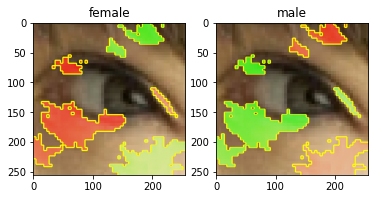

  0%|          | 0/2498 [00:00<?, ?it/s]

Partition explainer: 2it [07:45, 465.69s/it]              


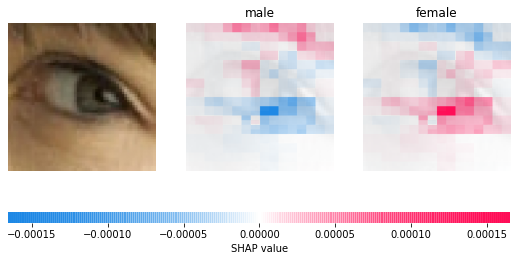

In [ ]:
# неправильно классифицированная женщина с низкой вероятностью принадлежности к классу
explain_lime_and_shap(false_low_female_img_path)

LIME на данном изображении относит к женским областям участок скулы и челки, которую скорее всего воспринимает как бровь, о мужчине свидетельстует область под нижним веком у переносицы. SHAP наоборот отмечает челку как мужской признак, а как женский нижнее веко.

## 2.1. Выводы

В целом данные методы не очень хорошо объясняют изображение. LIME Выделяет отдельные участки глаза и они часто указывают на одни и те же области (бровь, нижнее веко, углы глаза), однако эти области могут иметь разлиные размеры и не понятно, что именно на данном участке является важным для классификатора. SHAP дает очень размытое объяснение, некоторые единичные участки наоборот могут быть более ярко выраженными, что совсем неинтерпретируемо. Кромо того, в отличие от LIME, SHAP практически всегда выделяет область глазного яблока и интрерпретирует его как женский класс. Также оба метода для разной степени уверенности классификатора практически всегда выделяют большую долю участков изображения как объяснение противоположного класса, что не дает объяснение причин в различии между выделенными 4 группами для анализа.

# 3. Методы объяснения нейронных сетей.


## 3.1. Применение методов объяснения нейронных сетей.

### 3.1.1. Применение метода Gradients.


In [ ]:
LAYER_NAME='separable_conv2d_8'

gb_model = tf.keras.models.Model(
    inputs = [model.inputs],    
    outputs = [model.get_layer(LAYER_NAME).output]
)
# and then select the layers having activations
layer_dict = [layer for layer in gb_model.layers[1:] if hasattr(layer,'activation')]

In [ ]:
def get_img_array(image_path):
    img = keras.preprocessing.image.load_img(image_path, target_size=image_size)
    img_array = keras.preprocessing.image.img_to_array(img)

    # Image needs to be in the form of a batch
    return tf.expand_dims(img_array, 0)

In [ ]:
def backprop_method(image_path, relu_gradient=None):
  if relu_gradient is not None:
    for layer in layer_dict:
      layer.activation = relu_gradient
        
  source_img_array = get_img_array(image_path)
  with tf.GradientTape() as tape:
      inputs = tf.cast(source_img_array, tf.float32)
      tape.watch(inputs)
      outputs = gb_model(inputs)[0]
  grads = tape.gradient(outputs, inputs)[0]

  result_grads = grads
  gb_viz = np.dstack((
              result_grads[:, :, 0],
              result_grads[:, :, 1],
              result_grads[:, :, 2],
          )) 

  gb_viz -= np.min(gb_viz)
  gb_viz /= gb_viz.max()
  source_img = keras.preprocessing.image.load_img(image_path, target_size=image_size)

  fig, axarr = plt.subplots(1, 2)
  fig.set_size_inches(10.5, 7.5)
  axarr[0].imshow(gb_viz)
  axarr[1].imshow(source_img)
  plt.show()

In [ ]:
@tf.custom_gradient
def Grad(x):
    def grad(dy):
        return tf.cast(x>0, "float32") * dy
    return tf.nn.relu(x), grad

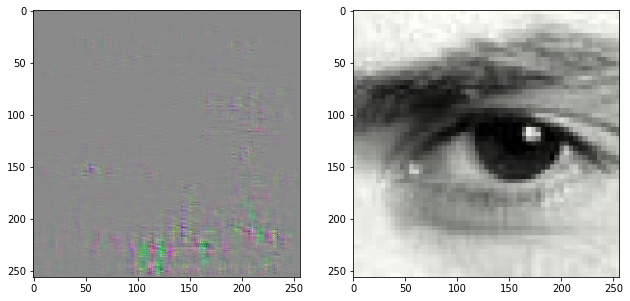

In [ ]:
# правильно классифицированный мужчина с высокой вероятностью принадлежности к классу
backprop_method(true_high_male_img_path, Grad)

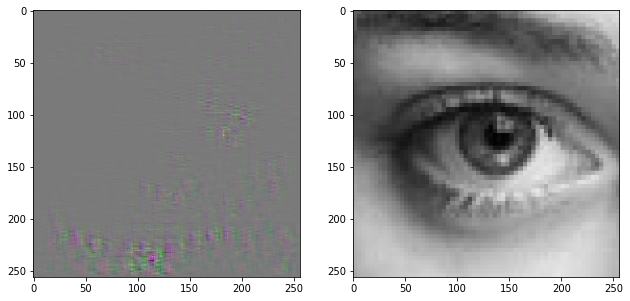

In [ ]:
# правильно классифицированная женщина с высокой вероятностью принадлежности к классу
backprop_method(true_high_female_img_path, Grad)

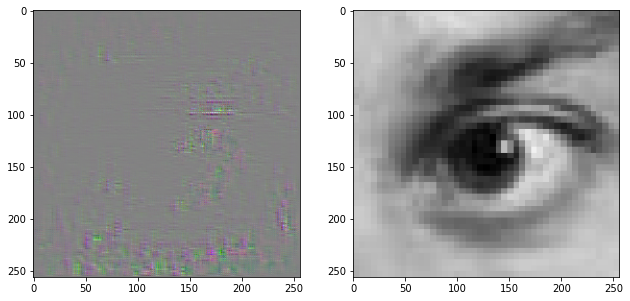

In [ ]:
# правильно классифицированный мужчина с низкой вероятностью принадлежности к классу
backprop_method(true_low_male_img_path, Grad)

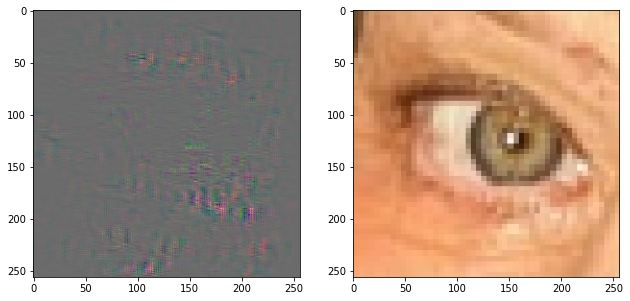

In [ ]:
# правильно классифицированная женщина с низкой вероятностью принадлежности к классу
backprop_method(true_low_female_img_path, Grad)

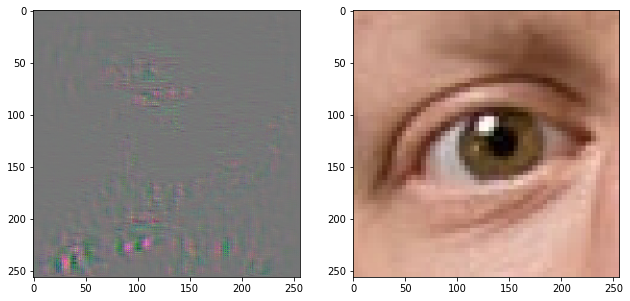

In [ ]:
# неправильно классифицированный мужчина с высокой вероятностью принадлежности к классу
backprop_method(false_lowest_male_img_path, Grad) 

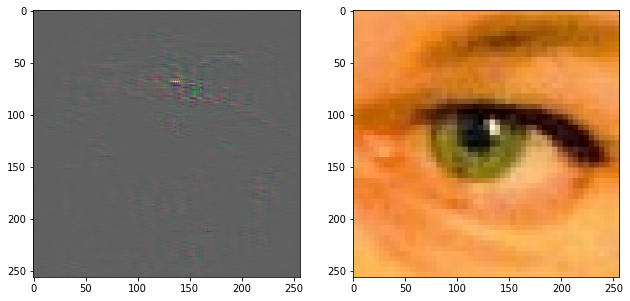

In [ ]:
# неправильно классифицированная женщина с высокой вероятностью принадлежности к классу
backprop_method(false_lowest_female_img_path, Grad)

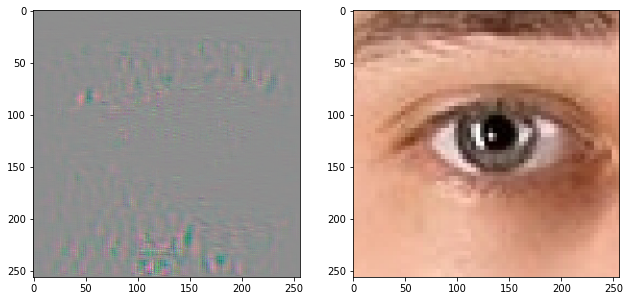

In [ ]:
# неправильно классифицированный мужчина с низкой вероятностью принадлежности к классу
backprop_method(false_low_male_img_path, Grad)

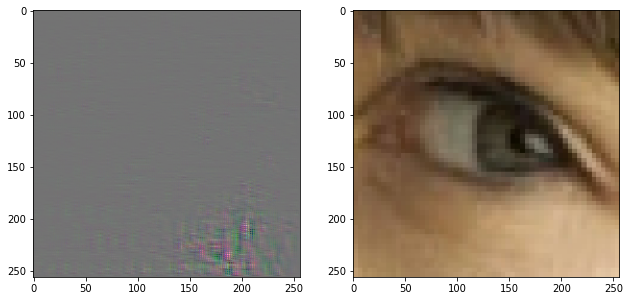

In [ ]:
# неправильно классифицированная женщина с низкой вероятностью принадлежности к классу
backprop_method(false_low_female_img_path, Grad)

### 3.1.2. Применение метода Guided Backpropagation.

In [ ]:
@tf.custom_gradient
def guidedRelu(x):
    def grad(dy):
        return tf.cast(dy>0,"float32") * tf.cast(x>0, "float32") * dy
    return tf.nn.relu(x), grad

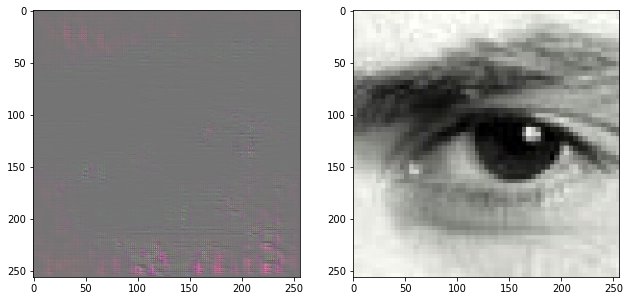

In [ ]:
# правильно классифицированный мужчина с высокой вероятностью принадлежности к классу
backprop_method(true_high_male_img_path, guidedRelu)

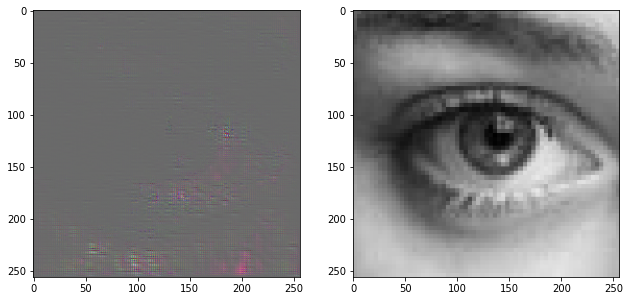

In [ ]:
# правильно классифицированная женщина с высокой вероятностью принадлежности к классу
backprop_method(true_high_female_img_path, guidedRelu)

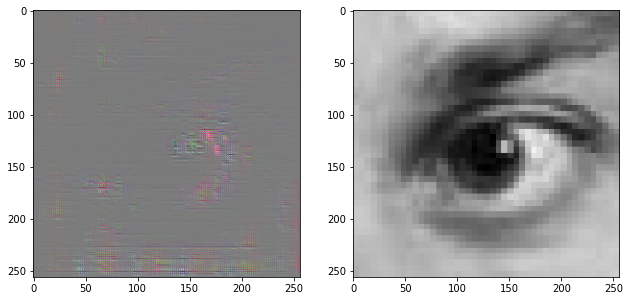

In [ ]:
# правильно классифицированный мужчина с низкой вероятностью принадлежности к классу
backprop_method(true_low_male_img_path, guidedRelu)

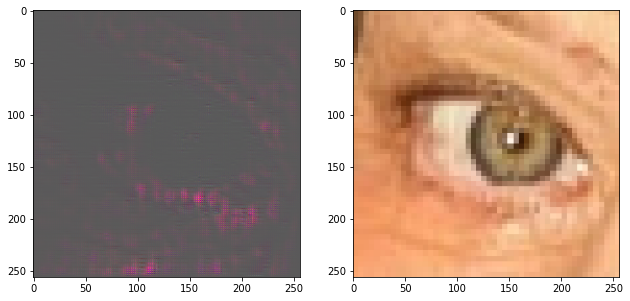

In [ ]:
# правильно классифицированная женщина с низкой вероятностью принадлежности к классу
backprop_method(true_low_female_img_path, guidedRelu)

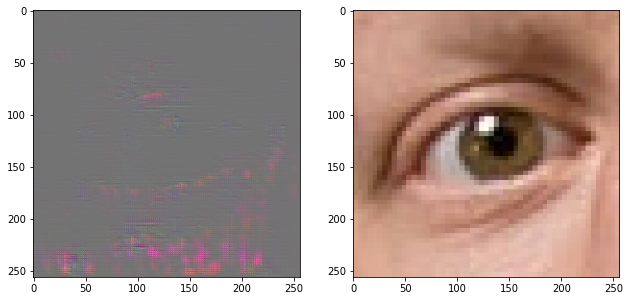

In [ ]:
# неправильно классифицированный мужчина с высокой вероятностью принадлежности к классу
backprop_method(false_lowest_male_img_path, guidedRelu) 

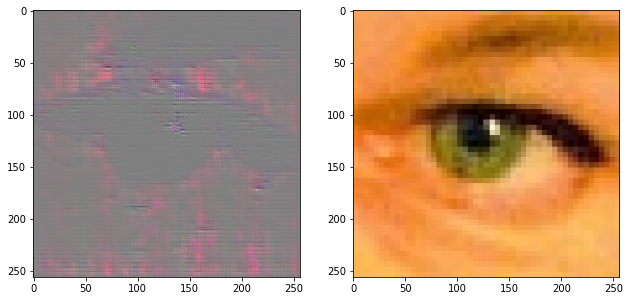

In [ ]:
# неправильно классифицированная женщина с высокой вероятностью принадлежности к классу
backprop_method(false_lowest_female_img_path, guidedRelu) 

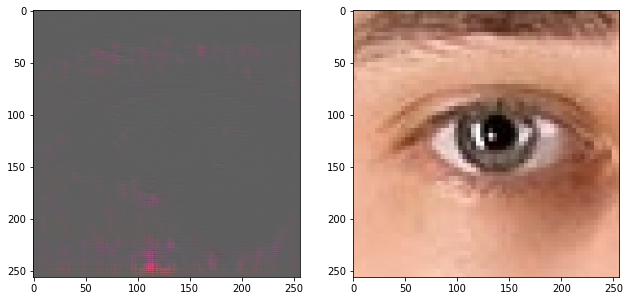

In [ ]:
# неправильно классифицированный мужчина с низкой вероятностью принадлежности к классу
backprop_method(false_low_male_img_path, guidedRelu)

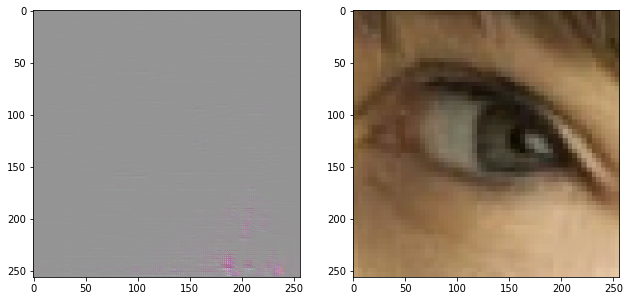

In [ ]:
# неправильно классифицированная женщина с низкой вероятностью принадлежности к классу
backprop_method(false_low_female_img_path, guidedRelu)

### 3.1.3. Применение метода Integrated Gradients.

In [ ]:
def get_image_array(image_path):
    img = keras.preprocessing.image.load_img(image_path, target_size=image_size)
    img_array = keras.preprocessing.image.img_to_array(img)
    return img_array / 255

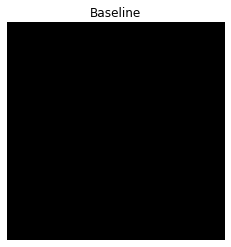

In [ ]:
baseline = tf.zeros(shape=(*image_size, 3))
plt.imshow(baseline)
plt.title("Baseline")
plt.axis('off')
plt.show()


In [ ]:
m_steps=50
alphas = tf.linspace(start=0.0, stop=1.0, num=m_steps + 1)

In [ ]:
def interpolate_images(baseline, image, alphas):
  alphas_x = alphas[:, tf.newaxis, tf.newaxis, tf.newaxis]
  baseline_x = tf.expand_dims(baseline, axis=0)
  input_x = tf.expand_dims(image, axis=0)
  delta = input_x - baseline_x
  images = baseline_x + alphas_x * delta
  return images

In [ ]:
interpolated_images = interpolate_images(
    baseline=baseline,
    image=get_image_array(true_high_male_img_path),
    alphas=alphas)


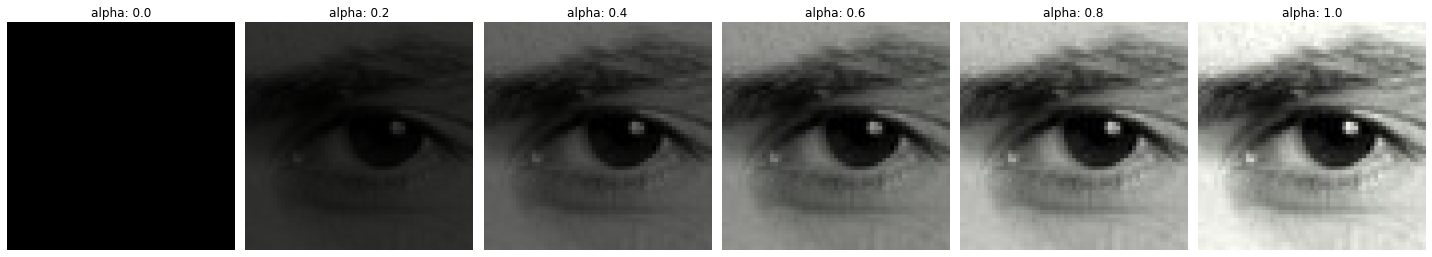

In [ ]:
fig = plt.figure(figsize=(20, 20))

i = 0
for alpha, image in zip(alphas[0::10], interpolated_images[0::10]):
  i += 1
  plt.subplot(1, len(alphas[0::10]), i)
  plt.title(f'alpha: {alpha:.1f}')
  plt.imshow(image)
  plt.axis('off')

plt.tight_layout();


In [ ]:
def compute_gradients(images, target_class_idx):
  images *= 255.
  with tf.GradientTape() as tape:
    tape.watch(images)
    logits = model(images)
    probs = tf.nn.softmax(logits, axis=-1)[:, target_class_idx]
  return tape.gradient(probs, images)

In [ ]:
path_gradients = compute_gradients(
    images=interpolated_images,
    target_class_idx=1)


In [ ]:
print(path_gradients.shape)

(51, 256, 256, 3)


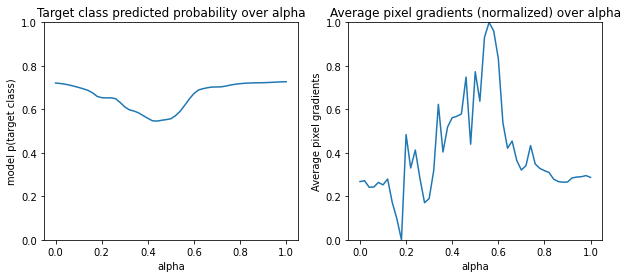

In [ ]:
pred = model(interpolated_images * 255.)
pred_proba = tf.nn.softmax(pred, axis=-1)[:, 1]

plt.figure(figsize=(10, 4))
ax1 = plt.subplot(1, 2, 1)
ax1.plot(alphas, pred_proba)
ax1.set_title('Target class predicted probability over alpha')
ax1.set_ylabel('model p(target class)')
ax1.set_xlabel('alpha')
ax1.set_ylim([0, 1])

ax2 = plt.subplot(1, 2, 2)
# Average across interpolation steps
average_grads = tf.reduce_mean(path_gradients, axis=[1, 2, 3])
# Normalize gradients to 0 to 1 scale. E.g. (x - min(x))/(max(x)-min(x))
average_grads_norm = (average_grads-tf.math.reduce_min(average_grads))/(tf.math.reduce_max(average_grads)-tf.reduce_min(average_grads))
ax2.plot(alphas, average_grads_norm)
ax2.set_title('Average pixel gradients (normalized) over alpha')
ax2.set_ylabel('Average pixel gradients')
ax2.set_xlabel('alpha')
ax2.set_ylim([0, 1]);


In [ ]:
def integral_approximation(gradients):
  # riemann_trapezoidal
  grads = (gradients[:-1] + gradients[1:]) / tf.constant(2.0)
  integrated_gradients = tf.math.reduce_mean(grads, axis=0)
  return integrated_gradients

In [ ]:
ig = integral_approximation(
    gradients=path_gradients)

In [ ]:
print(ig.shape)

(256, 256, 3)


In [ ]:
@tf.function
def integrated_gradients(baseline,
                         image,
                         target_class_idx,
                         m_steps=50,
                         batch_size=32):
  # 1. Generate alphas.
  alphas = tf.linspace(start=0.0, stop=1.0, num=m_steps+1)

  # Initialize TensorArray outside loop to collect gradients.    
  gradient_batches = tf.TensorArray(tf.float32, size=m_steps + 1)

  # Iterate alphas range and batch computation for speed, memory efficiency, and scaling to larger m_steps.
  for alpha in tf.range(0, len(alphas), batch_size):
    from_ = alpha
    to = tf.minimum(from_ + batch_size, len(alphas))
    alpha_batch = alphas[from_:to]

    # 2. Generate interpolated inputs between baseline and input.
    interpolated_path_input_batch = interpolate_images(baseline=baseline,
                                                       image=image,
                                                       alphas=alpha_batch)

    # 3. Compute gradients between model outputs and interpolated inputs.
    gradient_batch = compute_gradients(images=interpolated_path_input_batch,
                                       target_class_idx=target_class_idx)

    # Write batch indices and gradients to extend TensorArray.
    gradient_batches = gradient_batches.scatter(tf.range(from_, to), gradient_batch)    

  # Stack path gradients together row-wise into single tensor.
  total_gradients = gradient_batches.stack()

  # 4. Integral approximation through averaging gradients.
  avg_gradients = integral_approximation(gradients=total_gradients)

  # 5. Scale integrated gradients with respect to input.
  integrated_gradients = (image - baseline) * avg_gradients

  return integrated_gradients

In [ ]:
ig_attributions = integrated_gradients(baseline=baseline,
                                       image=get_image_array(true_high_male_img_path),
                                       target_class_idx=1,
                                       m_steps=120)


In [ ]:
def plot_img_attributions(baseline,
                          image,
                          target_class_idx,
                          m_steps=50,
                          cmap=None,
                          overlay_alpha=0.4):

  attributions = integrated_gradients(baseline=baseline,
                                      image=image,
                                      target_class_idx=target_class_idx,
                                      m_steps=m_steps)

  # Sum of the attributions across color channels for visualization.
  # The attribution mask shape is a grayscale image with height and width
  # equal to the original image.
  attribution_mask = tf.reduce_sum(tf.math.abs(attributions), axis=-1)

  fig, axs = plt.subplots(nrows=2, ncols=2, squeeze=False, figsize=(8, 8))

  axs[0, 0].set_title('Baseline image')
  axs[0, 0].imshow(baseline)
  axs[0, 0].axis('off')

  axs[0, 1].set_title('Original image')
  axs[0, 1].imshow(image)
  axs[0, 1].axis('off')

  axs[1, 0].set_title('Attribution mask')
  axs[1, 0].imshow(attribution_mask, cmap=cmap)
  axs[1, 0].axis('off')

  axs[1, 1].set_title('Overlay')
  axs[1, 1].imshow(attribution_mask, cmap=cmap)
  axs[1, 1].imshow(image, alpha=overlay_alpha)
  axs[1, 1].axis('off')

  plt.tight_layout()
  return fig

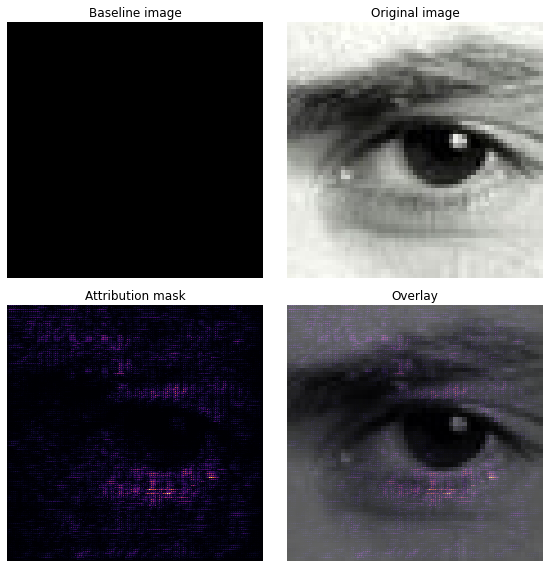

In [ ]:
_ = plot_img_attributions(image=get_image_array(true_high_male_img_path),
                          baseline=baseline,
                          target_class_idx=1,
                          m_steps=120,
                          cmap=plt.cm.inferno,
                          overlay_alpha=0.4)

In [ ]:
images_descriptions = []

# правильно классифицированный мужчина с высокой вероятностью принадлежности к классу
true_high_male_img_path = get_example(male_img_to_prediction, 1, 0.5, 0.99)
images_descriptions.append((true_high_male_img_path, 'правильно мужчина', 'высокая вероятность'))

# правильно классифицированная женщина с высокой вероятностью принадлежности к классу
true_high_female_img_path = get_example(female_img_to_prediction, 0, 0.01, 0.5)
images_descriptions.append((true_high_female_img_path, 'правильно женщина', 'высокая вероятность'))

# правильно классифицированный мужчина с низкой вероятностью принадлежности к классу
true_low_male_img_path = get_example(male_img_to_prediction, 1, 0.5, 0.6)
images_descriptions.append((true_low_male_img_path, 'правильно мужчина', 'низкая вероятность'))

# правильно классифицированная женщина с низкой вероятностью принадлежности к классу
true_low_female_img_path = get_example(female_img_to_prediction, 0, 0.4, 0.5)
images_descriptions.append((true_low_female_img_path, 'правильно женщина', 'низкая вероятность'))

# неправильно классифицированный мужчина с высокой вероятностью принадлежности к классу
false_lowest_male_img_path = get_example(male_img_to_prediction, 0, 0, 0.5)
images_descriptions.append((false_lowest_male_img_path, 'неправильно мужчина', 'высокая вероятность'))

# неправильно классифицированная женщина с высокой вероятностью принадлежности к классу
false_lowest_female_img_path = get_example(female_img_to_prediction, 1, 0.5, 1)
images_descriptions.append((false_lowest_female_img_path, 'неправильно женщина', 'высокая вероятность'))

# неправильно классифицированный мужчина с низкой вероятностью принадлежности к классу
false_low_male_img_path = get_example(male_img_to_prediction, 0, 0.4, 0.5)
images_descriptions.append((false_low_male_img_path, 'неправильно мужчина', 'низкая вероятность'))

# неправильно классифицированная женщина с низкой вероятностью принадлежности к классу
false_low_female_img_path = get_example(female_img_to_prediction, 1, 0.5, 0.6)
images_descriptions.append((false_low_female_img_path, 'неправильно женщина', 'низкая вероятность'))


In [ ]:
text2class = {
    'правильно мужчина':1,
    'неправильно мужчина':0,
    'правильно женщина':0,
    'неправильно женщина':1,
}

In [ ]:
def plot_images_attributions(baseline,
                          images_descriptions,
                          m_steps=20,
                          cmap=None,
                          overlay_alpha=0.4):

  fig, axs = plt.subplots(nrows=len(images_descriptions), ncols=2, squeeze=False, figsize=(8, 8 * 4))

  for i, (image_path, title1, title2) in enumerate(images_descriptions):
    
    image=get_image_array(image_path)
    attributions = integrated_gradients(baseline=baseline,
                                      image=image,
                                      target_class_idx=text2class[title1],
                                      m_steps=m_steps)

    attribution_mask = tf.reduce_sum(tf.math.abs(attributions), axis=-1)
  
    axs[i, 0].set_title(title1)
    axs[i, 0].imshow(attribution_mask, cmap=cmap)
    axs[i, 0].axis('off')

    axs[i, 1].set_title(title2)
    axs[i, 1].imshow(attribution_mask, cmap=cmap)
    axs[i, 1].imshow(image, alpha=overlay_alpha)
    axs[i, 1].axis('off')

  plt.tight_layout()
  return fig


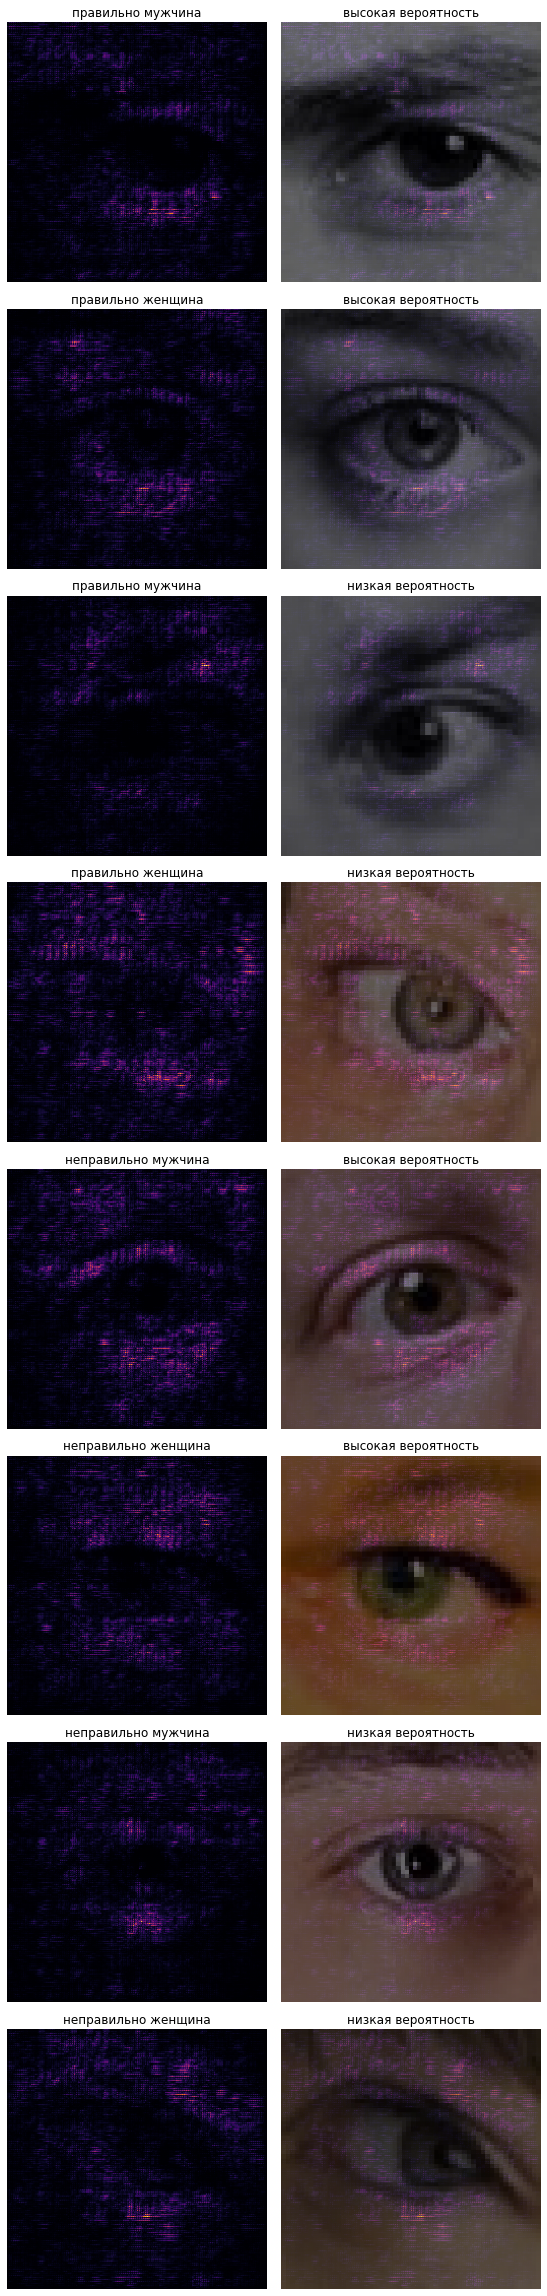

In [ ]:
_ = plot_images_attributions(baseline,
                            images_descriptions,
                            m_steps=120,
                            cmap=plt.cm.inferno,
                            overlay_alpha=0.4)

## 3.2. Сравнение работы методов объяснения нейронных сетей.

Среди рассмотренных методов наихудшее качество объяснения имеет Gradients. По полученным изображениям важности признаков трудно что-либо понять.
Объяснения других методов позволяют различить глаз и основные его части, но также не позволяют определить какие признаки повлияли на принятие решения о поле. В методе Integrated gradients, например, видно, что сам глаз - зрачок и глазное яблоко фактически не участвует в классификации.


Возможные варианты повышения интерпретируемости - попробовать выровнять глаз по горизонтали (по двум крайним точкам) и отзеркалировать глаз в одно из положений - правый или левый. Это может позволить более явно выделить важные для классификации части глаза уже на группах изображений со сходными вероятностями уверенности в классификации. 



## 3.3. Сравнение работы методов объяснения нейронных сетей с LIME и SHAP.

Объяснения рассмотренных методов отличаются от объяснений, построенных с помощью LIME и SHAP. Guided Backpropagation и Integrated Gradients дают более полное объяснение по сравнению с LIME и SHAP. 

#4.  Поиск контрфактических примеров.
 

In [ ]:
# importing the necessery modules
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
#from tensorflow.keras import models
from tensorflow.keras.preprocessing import image 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Dense
from keras.models import Model

import keras.backend as K 

In [ ]:
model = make_model(input_shape=image_size + (3,), num_classes=2)
model.load_weights('./model/model_parameters.h5')
model.compile(optimizer=keras.optimizers.Adam(1e-3), loss="sparse_categorical_crossentropy", metrics=["sparse_categorical_accuracy"])

In [ ]:
loss_object = tf.keras.losses.CategoricalCrossentropy()

def create_adversarial_pattern(input_image, input_label):
    expected = [[0, 0]]
    expected[0][input_label] = 1
    expected = tf.cast(expected, tf.float32)
    with tf.GradientTape() as tape:
        inputs = tf.cast(input_image, tf.float32)
        tape.watch(inputs)
        prediction = model(inputs)
        loss = loss_object(expected, prediction)

    # the gradients of the loss w.r.t to the input image.
    gradient = tape.gradient(loss, inputs)
    # the sign of the gradients to create the perturbation
    signed_grad = tf.sign(gradient)
    return signed_grad

In [ ]:
class_labels = ['female', 'male']
def find_advesarial_example(image_path, target_label, target_prob=0.5, eps=0.01):
  x_test = get_img_array(image_path)
  current_prob = model.predict(x_test)[0][target_label]
  adv_x = x_test
  while current_prob < target_prob:
    perturbations = create_adversarial_pattern(adv_x, target_label)
    perturbation_np = K.eval(perturbations)
    adv_x = 1 * adv_x - eps * perturbation_np
    current_prob = model.predict(adv_x)[0][target_label]

  fig, axs = plt.subplots(1, 2, figsize=(8, 6), dpi=80)
  axs[0].imshow(np.clip(adv_x / 255, 0, 1)[0]) 
  axs[0].set_title('P({class_label})={0:.2f}'.format(model.predict(adv_x)[0][target_label], class_label=class_labels[target_label]))

  axs[1].imshow(np.clip(100 * (x_test[0] - adv_x[0]) / 255, 0, 1)) 
  axs[1].set_title('Difference')


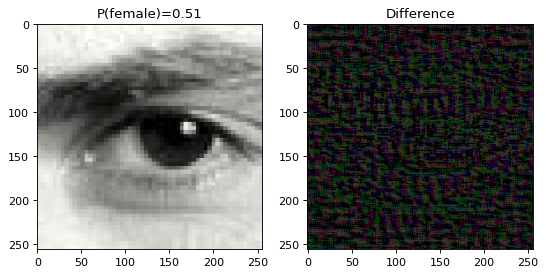

In [ ]:
# правильно классифицированный мужчина с высокой вероятностью принадлежности к классу
find_advesarial_example(true_high_male_img_path, 0)

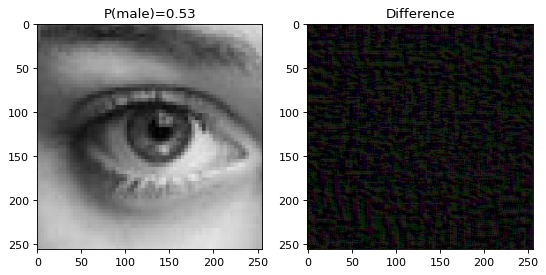

In [ ]:
# правильно классифицированная женщина с высокой вероятностью принадлежности к классу
find_advesarial_example(true_high_female_img_path, 1)

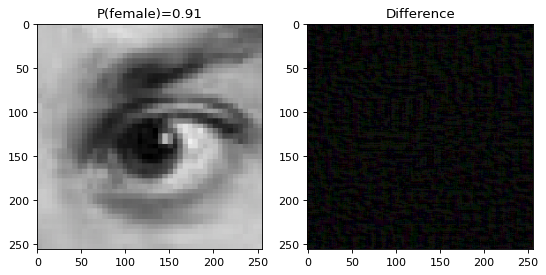

In [ ]:
# правильно классифицированный мужчина с низкой вероятностью принадлежности к классу
find_advesarial_example(true_low_male_img_path, target_prob=0.9, target_label=0)


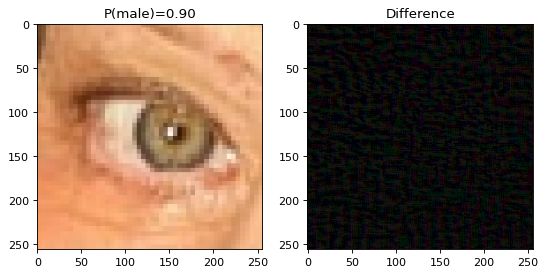

In [ ]:
# правильно классифицированная женщина с низкой вероятностью принадлежности к классу
find_advesarial_example(true_low_female_img_path, target_prob=0.9, target_label=1)


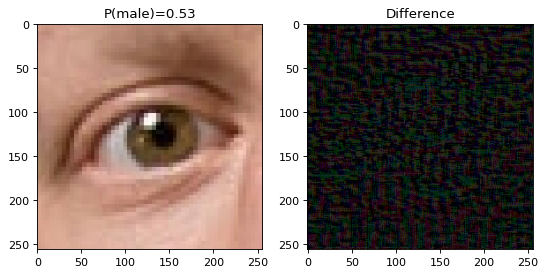

In [ ]:
# неправильно классифицированный мужчина с высокой вероятностью принадлежности к классу
find_advesarial_example(false_lowest_male_img_path, 1)

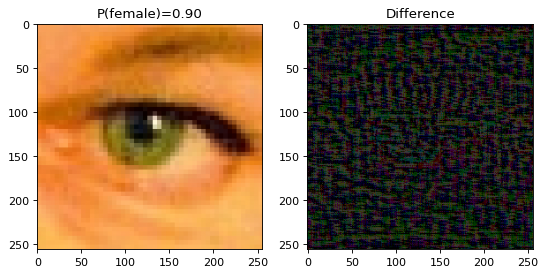

In [ ]:
# неправильно классифицированная женщина с высокой вероятностью принадлежности к классу
find_advesarial_example(false_lowest_female_img_path, target_prob=0.9, target_label=0)

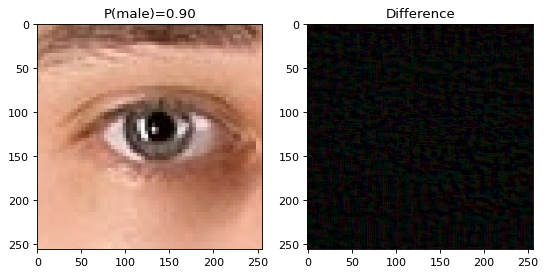

In [ ]:
# неправильно классифицированный мужчина с низкой вероятностью принадлежности к классу
find_advesarial_example(false_low_male_img_path, target_prob=0.9, target_label=1)

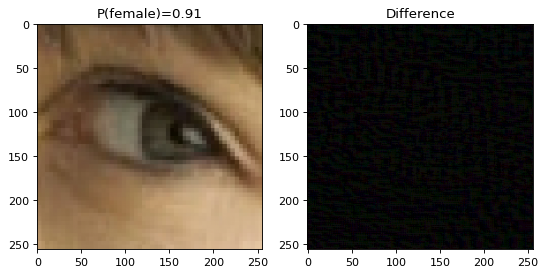

In [ ]:
# неправильно классифицированная женщина с низкой вероятностью принадлежности к классу
find_advesarial_example(false_low_female_img_path, target_prob=0.9, target_label=0)


Из построенных выше примеров можно заметить, что для изображений, у которых вероятности принадлежности к классам близки к 1, для построения контрфактических примеров потребовалось внести значительно больше искажений, чем для изображений со значениями вероятностей принадлежности к классу близкими к 0.5.

# Выводы. 

Среди рассмотренных алгоритмов наиболее интуитивно достоверные результаты показал метод Integrated Gradients, так как построенные им важности признаков ярче отражают части глаза (бровь, веко, нижняя часть глаза и др.), разделяя их между собой, по сравнению, с остальными методами. При этом результаты всех рассмотренных методов очень сложны для интерпретации, так как не позволяют понять почему модель приняла то или иное решение (чаще всего выделены одни и те же признаки для обоих классов).  